In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.4.0

import io
import os
import re
import shutil
import string
import tensorflow as tf
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,SnowballStemmer
from nltk.tokenize import TweetTokenizer
import pdb
import numpy as np
import pandas as pd
import nltk
from os import getcwd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow_hub as hub
import sys
sys.path.append('models')

from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data

In [ ]:
%cd "/content/drive/MyDrive/Big_Data/custom_model"

df = pd.read_csv("imdb_text.csv")

/content/drive/MyDrive/Big_Data/custom_model


In [ ]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.8, stratify=df.target.values)
valid_df, test_df = train_test_split(remaining, random_state=42, train_size=0.5, stratify=remaining.target.values)
train_df.shape, valid_df.shape,test_df.shape

((35708, 3), (4463, 3), (4464, 3))

#FINE TUNING BERT

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_df.target.values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_df.target.values))
test_data = tf.data.Dataset.from_tensor_slices((test_df.text.values, test_df.target.values))

for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'this movie stars ben kingsley as frank a hit man for some russian mobsters based out of buffalo he is also a raging alcoholic and this has caused his job performance to decline after he falls asleep in his car during a wouldbe hit his mob boss uncle sends him to san francisco where he is to attend aa meetings and get a job as a morticians assistant if youre thinking that this makes absolutely no sense youre not alone  it gets worse well it actually gets better but not before getting much much worse frank suddenly becomes a master mortician in spite of a complete lack of training but his reactions with the people in the funeral home and the aa meetings are interesting the viewer starts to root for him as they notice positive changes in his life luke wilson is a welcome addition as franks sponsor although he is given almost nothing to do his character does tell us he is gay but this ends up having no significance whatsoever the movie plunges headlong into idiocy with the intr

In [ ]:
label_list = [0, 1] # Label categories
max_seq_length = 125 # maximum length of (token) input sequences
train_batch_size = 32

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
print(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))
print(tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')))

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']
[7632, 29623, 2129, 2024, 2017, 2725, 29632]


In [ ]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid = None,
                                              text_a = text.numpy(), 
                                              text_b = None, 
                                              label = label.numpy())
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                      max_seq_length, tokenizer)
    
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                  Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

    # py_func doesn't set the shape of the returned tensors.
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
          'input_word_ids': input_ids,
          'input_mask': input_mask,
          'input_type_ids': segment_ids
      }
    return (x, label_id)

In [ ]:
# train
train_data = (train_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                        #.cache()
                        .shuffle(1000)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE))

# test
test_data = (test_data.map(to_feature_map,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE)) 

# valid
valid_data = (valid_data.map(to_feature_map,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE)) 


In [ ]:
def BERT_create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

    model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output)
    return model

In [ ]:
model_BERT = BERT_create_model()
model_BERT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_BERT.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 125)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 125)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 125)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 125, 768)]                'input_mask[0][0]',       

In [ ]:
# Train model
epochs = 4
history = model_BERT.fit(train_data,
                    validation_data = valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
1115/1115 [==============================] - 1967s 2s/step - loss: 0.3202 - binary_accuracy: 0.8594 - val_loss: 0.2479 - val_binary_accuracy: 0.8993
Epoch 2/4
1115/1115 [==============================] - 1952s 2s/step - loss: 0.1891 - binary_accuracy: 0.9256 - val_loss: 0.2679 - val_binary_accuracy: 0.8977
Epoch 3/4
1115/1115 [==============================] - 1952s 2s/step - loss: 0.1023 - binary_accuracy: 0.9627 - val_loss: 0.3801 - val_binary_accuracy: 0.8986
Epoch 4/4
1115/1115 [==============================] - 1950s 2s/step - loss: 0.0565 - binary_accuracy: 0.9807 - val_loss: 0.4143 - val_binary_accuracy: 0.8973


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


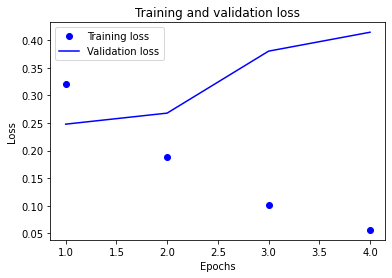

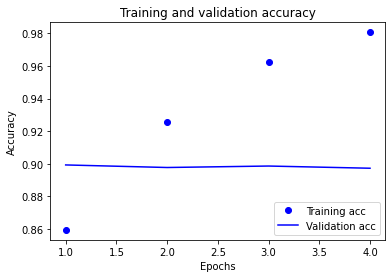

In [ ]:
history_dict = history.history
print(history_dict.keys())

#visualization
import matplotlib.pyplot as plt

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#training and validataion accuray
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
!cd "/content/drive/MyDrive/Big_Data/custom_model/" 
!mkdir -p saved_model

model_BERT.save('saved_model/my_model_BERT')

INFO:tensorflow:Assets written to: saved_model/my_model_BERT/assets


INFO:tensorflow:Assets written to: saved_model/my_model_BERT/assets


In [ ]:
model_BERT.evaluate(test_data)

139/139 [==============================] - 83s 589ms/step - loss: 0.4342 - binary_accuracy: 0.8939


[0.43420737981796265, 0.8938848972320557]

In [ ]:
def predict(sentence):
    sample_example = [sentence]
    test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
    test_data = (test_data.map(to_feature_map).batch(1))
    preds = model_BERT.predict(test_data)
    if preds >= 0.5:
       return "positive"
    return "negative"

In [ ]:
sentence = "hey you are terrible and i don't want you"
predict(sentence)

'negative'

In [ ]:
sentence = "happy birthday, you are my everything"
predict(sentence)

'positive'

In [ ]:
sentence = "i'm so terriable"
predict(sentence)

'negative'